In [1]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)


# == Step1 ==：模型合并

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [2]:
# == Step2 ==：添加最后一层，做我们自己的2分类模型

from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


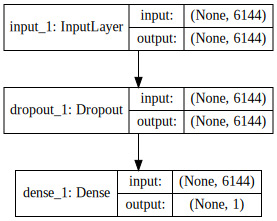

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
model.fit(X_train, y_train, batch_size=128, epochs=100, validation_split=0.2)

Train on 160 samples, validate on 40 samples
Epoch 1/100
160/160 [==============================] - 0s - loss: 0.0819 - acc: 0.9813 - val_loss: 0.1084 - val_acc: 0.9750
Epoch 2/100
160/160 [==============================] - 0s - loss: 0.0815 - acc: 0.9875 - val_loss: 0.0924 - val_acc: 0.9750
Epoch 3/100
160/160 [==============================] - 0s - loss: 0.0723 - acc: 1.0000 - val_loss: 0.0932 - val_acc: 0.9750
Epoch 4/100
160/160 [==============================] - 0s - loss: 0.0638 - acc: 0.9938 - val_loss: 0.0932 - val_acc: 0.9750
Epoch 5/100
160/160 [==============================] - 0s - loss: 0.0689 - acc: 0.9938 - val_loss: 0.0903 - val_acc: 0.9750
Epoch 6/100
160/160 [==============================] - 0s - loss: 0.0686 - acc: 0.9938 - val_loss: 0

In [14]:
model.save('model.h5')

In [15]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

 864/1432 [=================>............] - ETA: 0s

In [16]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test-small-dataset", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

Found 100 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
